In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import regularizers

Using TensorFlow backend.


In [7]:
pd.options.display.max_columns = None

### Importing Data

In [9]:
raw_data = pd.read_csv("Hotel Data\H1.csv")
df = raw_data.copy()

In [10]:
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [11]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
      dtype='object')

In [12]:
df.ReservedRoomType.value_counts()

A                   23399
D                    7433
E                    4982
G                    1610
F                    1106
C                     918
H                     601
L                       6
B                       3
P                       2
Name: ReservedRoomType, dtype: int64

In [13]:
df.AssignedRoomType.value_counts()

A                   17046
D                   10339
E                    5638
C                    2214
G                    1853
F                    1733
H                     712
I                     363
B                     159
P                       2
L                       1
Name: AssignedRoomType, dtype: int64

### Ordering Months

In [14]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
df['ArrivalDateMonth'] = pd.Categorical(df['ArrivalDateMonth'], categories=months, ordered=True)

### Per RoomType, Per CustomerSegment vs Demand

In [37]:
pred_df = df.pivot_table( index = ['ArrivalDateYear','ArrivalDateWeekNumber'], aggfunc='count', values='ADR', columns=['AssignedRoomType','MarketSegment'])
pred_df = pred_df.fillna(0)

In [38]:
pred_df

AssignedRoomType                      A                                  \
MarketSegment                            Complementary Corporate Direct   
ArrivalDateYear ArrivalDateWeekNumber                                     
2015            27                                 0.0       1.0    6.0   
                28                                 0.0       5.0   19.0   
                29                                 0.0       3.0   14.0   
                30                                 0.0       3.0   20.0   
                31                                 0.0       1.0   12.0   
...                                                ...       ...    ...   
2017            31                                 0.0       1.0   26.0   
                32                                 0.0       1.0   21.0   
                33                                 0.0       2.0   26.0   
                34                                 0.0       2.0   12.0   
                35                                 2.0       0.0   12.0   

AssignedRoomType                                                      \
MarketSegment                         Groups Offline TA/TO Online TA   
ArrivalDateYear ArrivalDateWeekNumber                                  
2015            27                       0.0          26.0      31.0   
                28                       0.0          38.0      49.0   
                29                      34.0          42.0      64.0   
                30                       0.0          40.0      58.0   
                31                       0.0          48.0      64.0   
...                                      ...           ...       ...   
2017            31                       0.0          28.0     111.0   
                32                       0.0          33.0      93.0   
                33                       0.0          32.0     124.0   
                34                       0.0          43.0      97.0   
                35                       0.0          16.0      79.0   

AssignedRoomType                      B                               \
MarketSegment                                Corporate Direct Groups   
ArrivalDateYear ArrivalDateWeekNumber                                  
2015            27                                 1.0    0.0    0.0   
                28                                 0.0    0.0    0.0   
                29                                 0.0    0.0    0.0   
                30                                 0.0    1.0    0.0   
                31                                 0.0    1.0    0.0   
...                                                ...    ...    ...   
2017            31                                 1.0    0.0    0.0   
                32                                 0.0    0.0    0.0   
                33                                 1.0    1.0    0.0   
                34                                 0.0    0.0    0.0   
                35                                 0.0    0.0    0.0   

AssignedRoomType                                               \
MarketSegment                         Offline TA/TO Online TA   
ArrivalDateYear ArrivalDateWeekNumber                           
2015            27                              1.0       0.0   
                28                              1.0       0.0   
                29                              0.0       2.0   
                30                              0.0       0.0   
                31                              0.0       0.0   
...                                             ...       ...   
2017            31                              0.0       2.0   
                32                              0.0       2.0   
                33                              0.0       4.0   
                34                              0.0       1.0   
                35                              1.0       0.0   

AssignedRoomType    

In [17]:
selected_col = pred_df.columns[5]

In [18]:
pred_df[selected_col]

ArrivalDateYear  ArrivalDateWeekNumber
2015             27                        31.0
                 28                        49.0
                 29                        64.0
                 30                        58.0
                 31                        64.0
                                          ...  
2017             31                       111.0
                 32                        93.0
                 33                       124.0
                 34                        97.0
                 35                        79.0
Name: (A               , Online TA), Length: 115, dtype: float64

In [19]:
df_lstm = pred_df[selected_col]
df_lstm.shape

(115,)

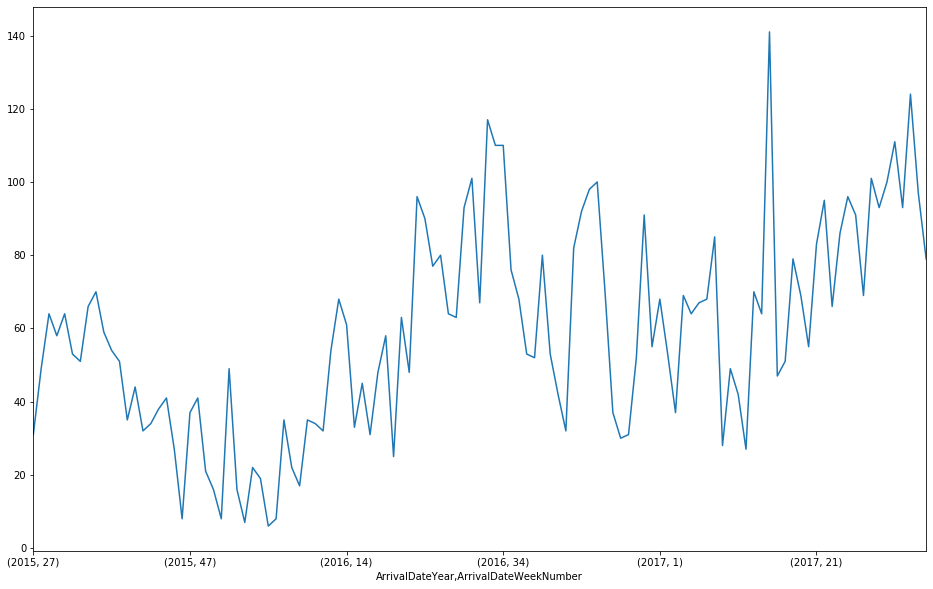

In [35]:
df_lstm.plot(figsize=(16,10))

#### Adding ADR

In [21]:
col_ADR = df.pivot_table( index = ['ArrivalDateYear','ArrivalDateWeekNumber'], aggfunc='mean', values='ADR', columns=['AssignedRoomType','MarketSegment'])
col_ADR = pred_df.fillna(0)

In [22]:
col_ADR = col_ADR[selected_col]

In [23]:
col_ADR

ArrivalDateYear  ArrivalDateWeekNumber
2015             27                        31.0
                 28                        49.0
                 29                        64.0
                 30                        58.0
                 31                        64.0
                                          ...  
2017             31                       111.0
                 32                        93.0
                 33                       124.0
                 34                        97.0
                 35                        79.0
Name: (A               , Online TA), Length: 115, dtype: float64

### Joining Columns

In [24]:
new_df = pd.DataFrame(df_lstm)
new_df['ADR'] = col_ADR

In [25]:
new_df = new_df.reset_index()

In [26]:
new_df.columns = ['Year', 'Week', 'Demand', 'ADR']

In [27]:
new_df

,Year,Week,Demand,ADR
0,2015,27,31.0,31.0
1,2015,28,49.0,49.0
2,2015,29,64.0,64.0
3,2015,30,58.0,58.0
4,2015,31,64.0,64.0
...,...,...,...,...
110,2017,31,111.0,111.0
111,2017,32,93.0,93.0
112,2017,33,124.0,124.0
113,2017,34,97.0,97.0


In [28]:
new_df.shape

(115, 4)

In [29]:
new_df[['Demand', 'ADR']]

,Demand,ADR
0,31.0,31.0
1,49.0,49.0
2,64.0,64.0
3,58.0,58.0
4,64.0,64.0
...,...,...
110,111.0,111.0
111,93.0,93.0
112,124.0,124.0
113,97.0,97.0


### Creating Sequences

In [30]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix][0]
		X.append(seq_x)
		y.append(seq_y)
	return np.asarray(X), np.asarray(y)

In [31]:
np.asarray(df_lstm)

array([ 31.,  49.,  64.,  58.,  64.,  53.,  51.,  66.,  70.,  59.,  54.,
        51.,  35.,  44.,  32.,  34.,  38.,  41.,  27.,   8.,  37.,  41.,
        21.,  16.,   8.,  49.,  16.,   7.,  22.,  19.,   6.,   8.,  35.,
        22.,  17.,  35.,  34.,  32.,  54.,  68.,  61.,  33.,  45.,  31.,
        48.,  58.,  25.,  63.,  48.,  96.,  90.,  77.,  80.,  64.,  63.,
        93., 101.,  67., 117., 110., 110.,  76.,  68.,  53.,  52.,  80.,
        53.,  42.,  32.,  82.,  92.,  98., 100.,  70.,  37.,  30.,  31.,
        52.,  91.,  55.,  68.,  53.,  37.,  69.,  64.,  67.,  68.,  85.,
        28.,  49.,  42.,  27.,  70.,  64., 141.,  47.,  51.,  79.,  69.,
        55.,  83.,  95.,  66.,  86.,  96.,  91.,  69., 101.,  93., 100.,
       111.,  93., 124.,  97.,  79.])

In [32]:
n_steps = 10
n_features = 2

In [36]:
X, y = split_sequence(np.asarray(new_df[['Demand','ADR']]), n_steps)

In [34]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [29]:
X.shape

(105, 10, 2)

In [30]:
y

array([ 54.,  51.,  35.,  44.,  32.,  34.,  38.,  41.,  27.,   8.,  37.,
        41.,  21.,  16.,   8.,  49.,  16.,   7.,  22.,  19.,   6.,   8.,
        35.,  22.,  17.,  35.,  34.,  32.,  54.,  68.,  61.,  33.,  45.,
        31.,  48.,  58.,  25.,  63.,  48.,  96.,  90.,  77.,  80.,  64.,
        63.,  93., 101.,  67., 117., 110., 110.,  76.,  68.,  53.,  52.,
        80.,  53.,  42.,  32.,  82.,  92.,  98., 100.,  70.,  37.,  30.,
        31.,  52.,  91.,  55.,  68.,  53.,  37.,  69.,  64.,  67.,  68.,
        85.,  28.,  49.,  42.,  27.,  70.,  64., 141.,  47.,  51.,  79.,
        69.,  55.,  83.,  95.,  66.,  86.,  96.,  91.,  69., 101.,  93.,
       100., 111.,  93., 124.,  97.,  79.])

### Training Testing Split

In [31]:
X_train = X[0:80]
X_test = X[80:]
y_train = y[0:80]
y_test = y[80:]

### LSTM Model

In [32]:
# define model
model = Sequential()
model.add(LSTM(50, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [33]:
# fit model
history = model.fit(X_train, y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




### Checking History

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,loss,epoch
295,753.887146,2.162305,295
296,742.722778,2.004070,296
297,749.372620,1.909193,297
298,737.308044,2.063558,298
299,731.905762,1.971563,299


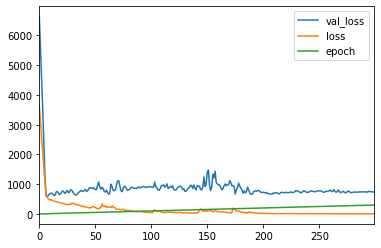

In [35]:
hist.plot()

### Prediction

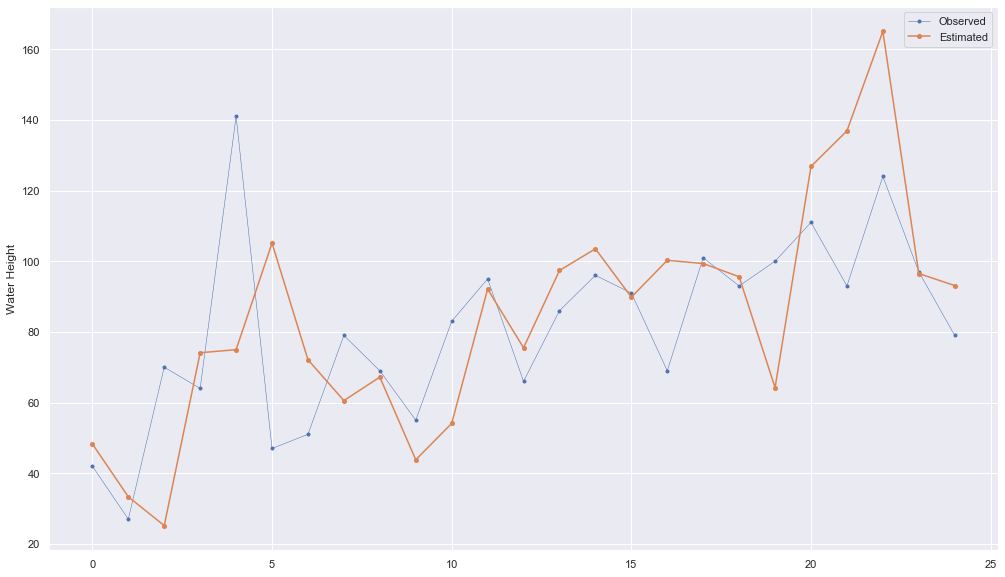

In [36]:
yhat = model.predict(X_test, verbose=0)
y_test=y_test.reshape(y_test.shape[0],1)

sns.set(rc={'figure.figsize':(17, 10)})
fig, ax = plt.subplots()
ax.plot(y_test, marker='.', linestyle='-', linewidth=0.5, label='Observed')
ax.plot(yhat, marker='.', markersize=8, linestyle='-', label='Estimated')
ax.set_ylabel('Water Height')
ax.legend();